In [147]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [3]:
df= pd.read_excel("/content/yepyeni_bisiklet1.xlsx")

In [4]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe().T)
   
   

check_df(df)

##################### Shape #####################
(17379, 14)
##################### Types #####################
season            int64
year              int64
month             int64
hour              int64
weekday           int64
workingday        int64
weather           int64
temperature     float64
atemperature    float64
humidity        float64
windspeed       float64
unregistered      int64
registered        int64
total             int64
dtype: object
##################### Head #####################
   season  year  month  hour  weekday  workingday  weather  temperature  atemperature  humidity  windspeed  unregistered  registered  total
0       1     0      1     0        6           0        1        0.240         0.288     0.810      0.000             3          13     16
1       1     0      1     1        6           0        1        0.220         0.273     0.800      0.000             8          32     40
2       1     0      1     2        6           0        1        0.2

In [5]:
df.apply(lambda x: len(x.unique()))  #uniqueler değer kaç tane

season            4
year              2
month            12
hour             24
weekday           7
workingday        2
weather           4
temperature      50
atemperature     65
humidity         89
windspeed        30
unregistered    322
registered      776
total           869
dtype: int64

In [6]:
#import datetime as dt

In [7]:
df.dtypes

season            int64
year              int64
month             int64
hour              int64
weekday           int64
workingday        int64
weather           int64
temperature     float64
atemperature    float64
humidity        float64
windspeed       float64
unregistered      int64
registered        int64
total             int64
dtype: object

In [8]:
#datetime değiştircez 

#df['year'] =pd.to_datetime(df['year'])
#df['month'] =pd.to_datetime(df['month'])




In [9]:

df.dtypes

season            int64
year              int64
month             int64
hour              int64
weekday           int64
workingday        int64
weather           int64
temperature     float64
atemperature    float64
humidity        float64
windspeed       float64
unregistered      int64
registered        int64
total             int64
dtype: object

In [10]:
# Feature Türetmek

df["hour_category"]= pd.cut(df["hour"], ([-1,5, 11, 17, 23]),labels=[1, 2, 3, 4]) #1,2,3,4 Gece, Sabah, Öğleden sonra, Akşam
df["temperature_category"] = pd.cut(df["temperature"], bins=[0, 0.2, 0.4, 0.6, 0.8, 1], labels=[1, 2, 3, 4, 5])  #Çok soğuk", "Soğuk", "Ilık", "Sıcak", "Çok sıcak"

df["humidity_ratio"] = pd.cut(df["humidity"], bins=3 , labels=[1, 2, 3])  #Düşük, Orta, Yüksek
df["humidity_temperature_relations"] = df["humidity"] * df["temperature"]




In [11]:
df['weekday'] = df["weekday"].replace(0, 7)

In [12]:
df[df['weekday'] ==0].head(200)



,season,year,month,hour,weekday,workingday,weather,temperature,atemperature,humidity,windspeed,unregistered,registered,total,hour_category,temperature_category,humidity_ratio,humidity_temperature_relations


In [13]:
def grab_col_names(dataframe, cat_th=25, car_th=30):  #
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 17379
Variables: 18
cat_cols: 10
num_cols: 8
cat_but_car: 0
num_but_cat: 10


In [14]:
cat_cols

['season',
 'year',
 'month',
 'hour',
 'weekday',
 'workingday',
 'weather',
 'hour_category',
 'temperature_category',
 'humidity_ratio']

In [15]:
num_cols

['temperature',
 'atemperature',
 'humidity',
 'windspeed',
 'unregistered',
 'registered',
 'total',
 'humidity_temperature_relations']

In [16]:
cat_but_car

[]

In [17]:
df['season']=df.season.astype('category')
df['year']=df.year.astype('category')
df['month']=df.month.astype('category')
df['weekday']=df.weekday.astype('category')
df['workingday']=df.workingday.astype('category')

In [18]:
#buarada hem kat hem de nümerik grafikler gelicek atladık

In [19]:
df.dtypes

season                            category
year                              category
month                             category
hour                                 int64
weekday                           category
workingday                        category
weather                              int64
temperature                        float64
atemperature                       float64
humidity                           float64
windspeed                          float64
unregistered                         int64
registered                           int64
total                                int64
hour_category                     category
temperature_category              category
humidity_ratio                    category
humidity_temperature_relations     float64
dtype: object

In [20]:
#eda tablolar geçtik

[Text(0.5, 1.0, 'Number of Bicycle Usage by Time of Day'),
 Text(0.5, 0, 'hour'),
 Text(0, 0.5, 'total')]

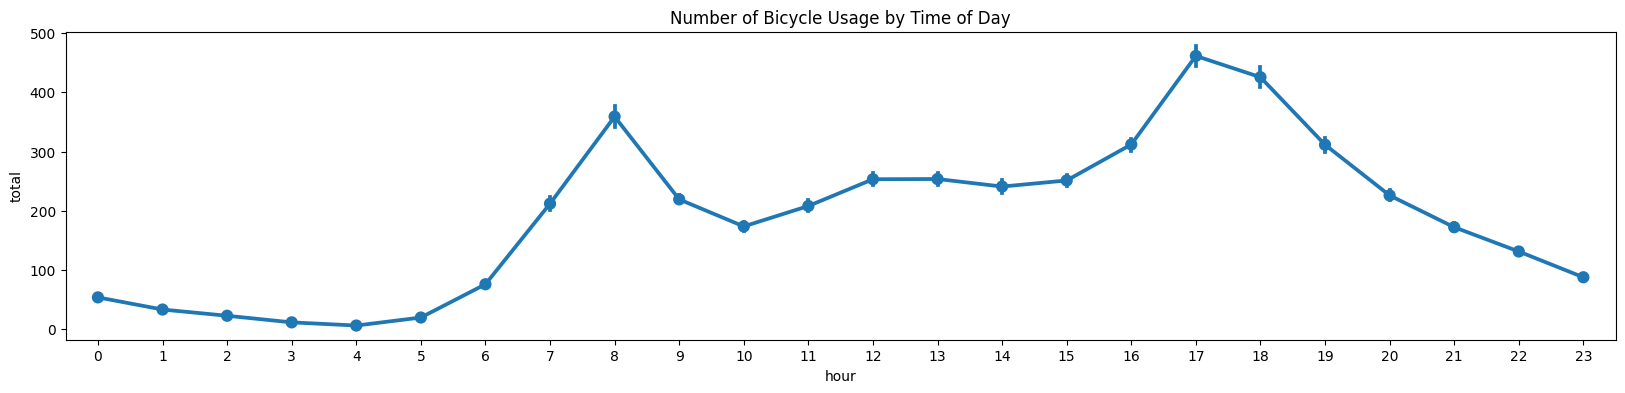

In [21]:
#Tablo 1

fig, ax = plt.subplots(figsize=(20,4))
sns.pointplot(data=df, x='hour', y='total', ax=ax)
ax.set(title="Number of Bicycle Usage by Time of Day", xlabel="hour", ylabel="total")

[Text(0.5, 1.0, 'Number of Bicycle Usage by Days and Hours'),
 Text(0.5, 0, 'hour'),
 Text(0, 0.5, 'total')]

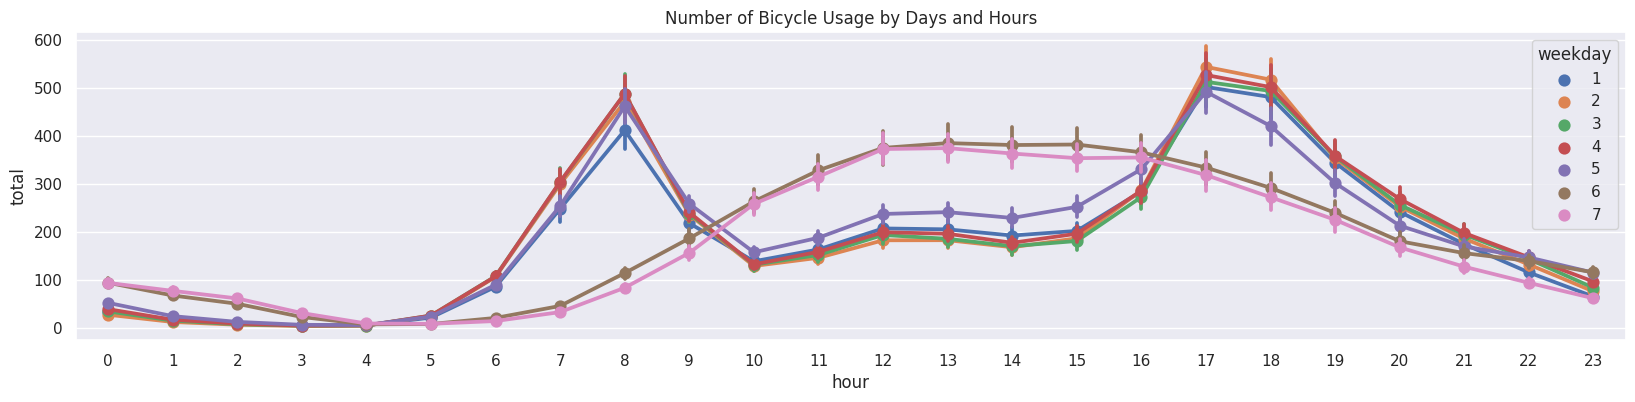

In [135]:
#Tablo 2
fig, ax = plt.subplots(figsize=(20,4))
sns.pointplot(data=df, x='hour', y='total', hue='weekday', ax=ax)
ax.set(title="Number of Bicycle Usage by Days and Hours", xlabel="hour", ylabel="total")

[Text(0.5, 1.0, 'Number of Bicycle Usage by Days and Hours: Unregistered Users'),
 Text(0.5, 0, 'hour'),
 Text(0, 0.5, 'total')]

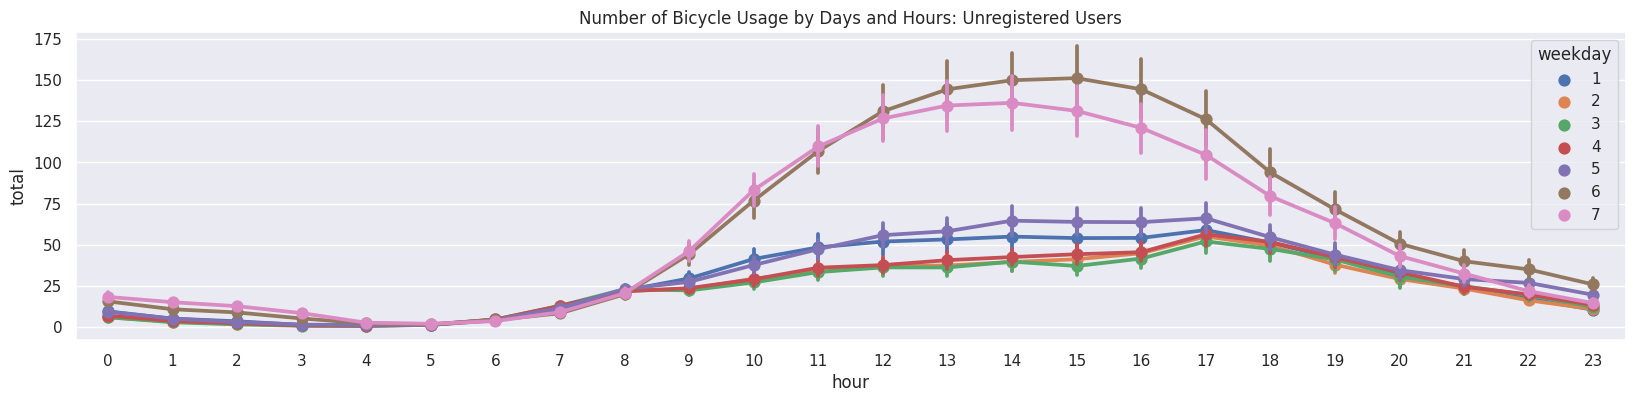

In [138]:
#Tablo 3
fig, ax = plt.subplots(figsize=(20,4))
sns.pointplot(data=df, x='hour', y='unregistered', hue="weekday", ax=ax)
ax.set(title="Number of Bicycle Usage by Days and Hours: Unregistered Users", xlabel="hour", ylabel="total")

[Text(0.5, 1.0, 'Number of Bicycle Usage by Days and Hours: Registered Users'),
 Text(0.5, 0, 'hour'),
 Text(0, 0.5, 'total')]

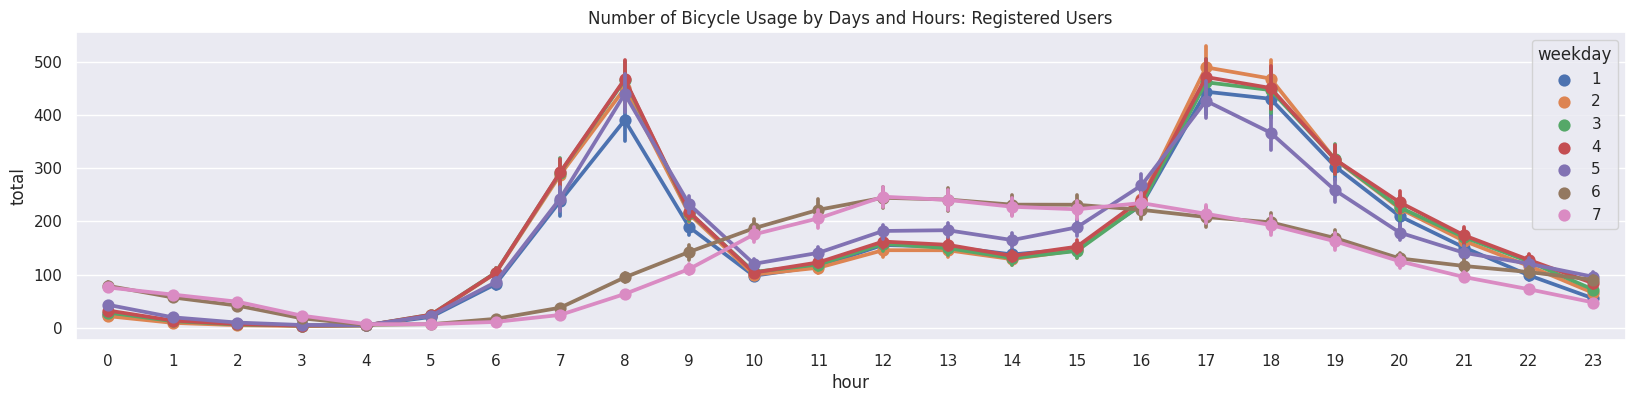

In [137]:
#Tablo 4
fig, ax = plt.subplots(figsize=(20,4))
sns.pointplot(data=df, x='hour', y='registered', hue='weekday', ax=ax)
ax.set(title="Number of Bicycle Usage by Days and Hours: Registered Users", xlabel="hour", ylabel="total")

[Text(0.5, 1.0, 'Number of Bicycle Usage by Days and Hours: Registered Users'),
 Text(0.5, 0, 'hour'),
 Text(0, 0.5, 'total')]

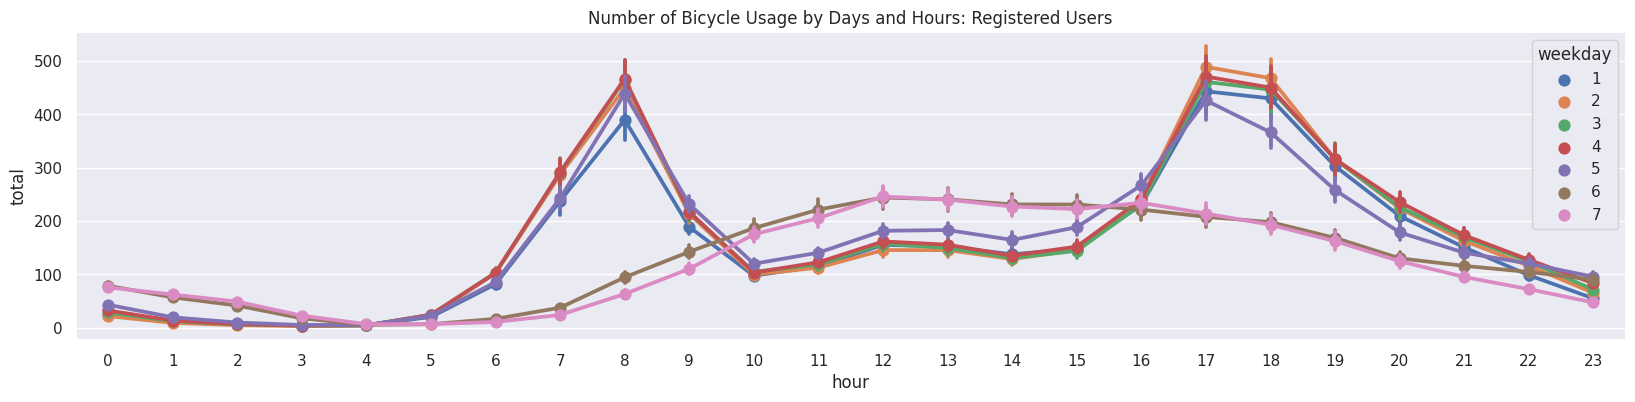

In [139]:
#Tablo 4
fig, ax = plt.subplots(figsize=(20,4))
sns.pointplot(data=df, x='hour', y='registered', hue='weekday', ax=ax)
ax.set(title="Number of Bicycle Usage by Days and Hours: Registered Users", xlabel="hour", ylabel="total")

[Text(0.5, 1.0, 'Bicycle Usage by Seasons'),
 Text(0.5, 0, 'hour'),
 Text(0, 0.5, 'total')]

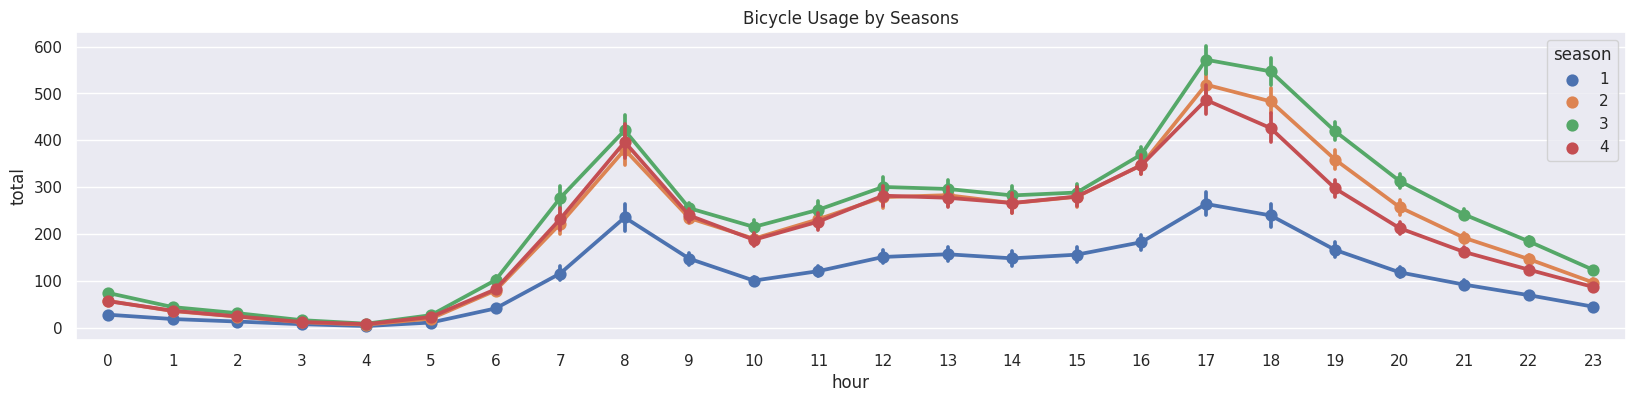

In [140]:
#Tablo 5
fig, ax = plt.subplots(figsize=(20,4))
sns.pointplot(data=df, x='hour', y='total', hue='season', ax=ax)
ax.set(title="Bicycle Usage by Seasons", xlabel="hour", ylabel="total")

[Text(0.5, 1.0, 'Bicycle Usage by Weather'),
 Text(0.5, 0, 'hour'),
 Text(0, 0.5, 'total')]

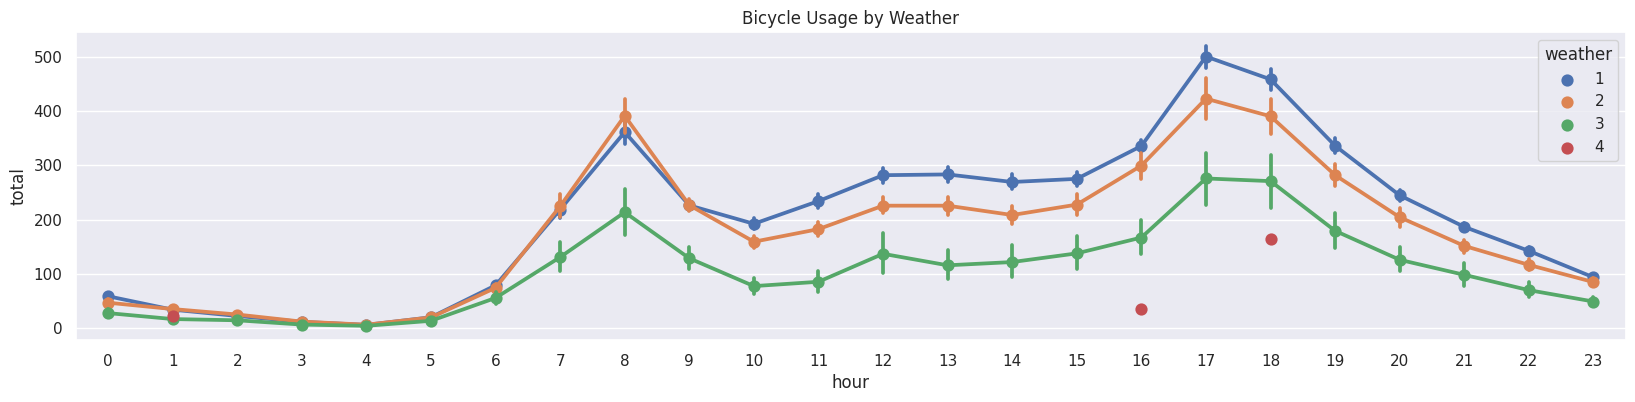

In [141]:
#Tablo 5
fig, ax = plt.subplots(figsize=(20,4))
sns.pointplot(data=df, x='hour', y='total', hue='weather', ax=ax)
ax.set(title="Bicycle Usage by Weather", xlabel="hour", ylabel="total")
#burada yağmurlı vb isimlerini yazalım

[Text(0.5, 1.0, 'Number of Bicycle Usage by Months'),
 Text(0.5, 0, 'months'),
 Text(0, 0.5, 'total')]

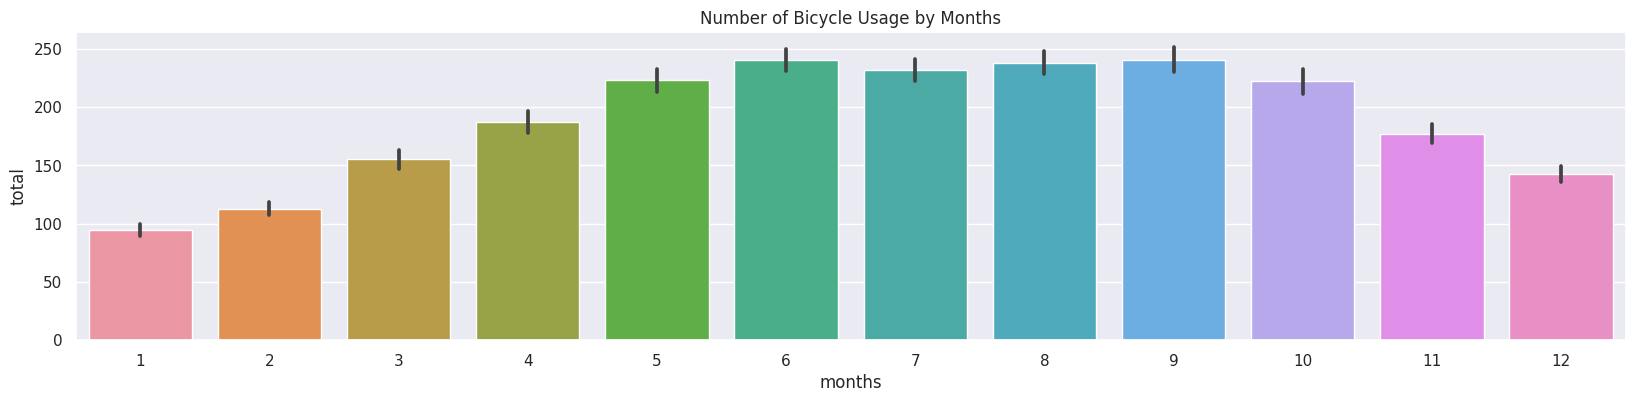

In [142]:
#Tablo 7
fig, ax = plt.subplots(figsize=(20,4))
sns.barplot(data=df, x='month', y='total', ax=ax)
ax.set(title="Number of Bicycle Usage by Months", xlabel="months", ylabel="total")

[Text(0.5, 1.0, 'Number of Bicycle Usage by Days'),
 Text(0.5, 0, 'days'),
 Text(0, 0.5, 'total')]

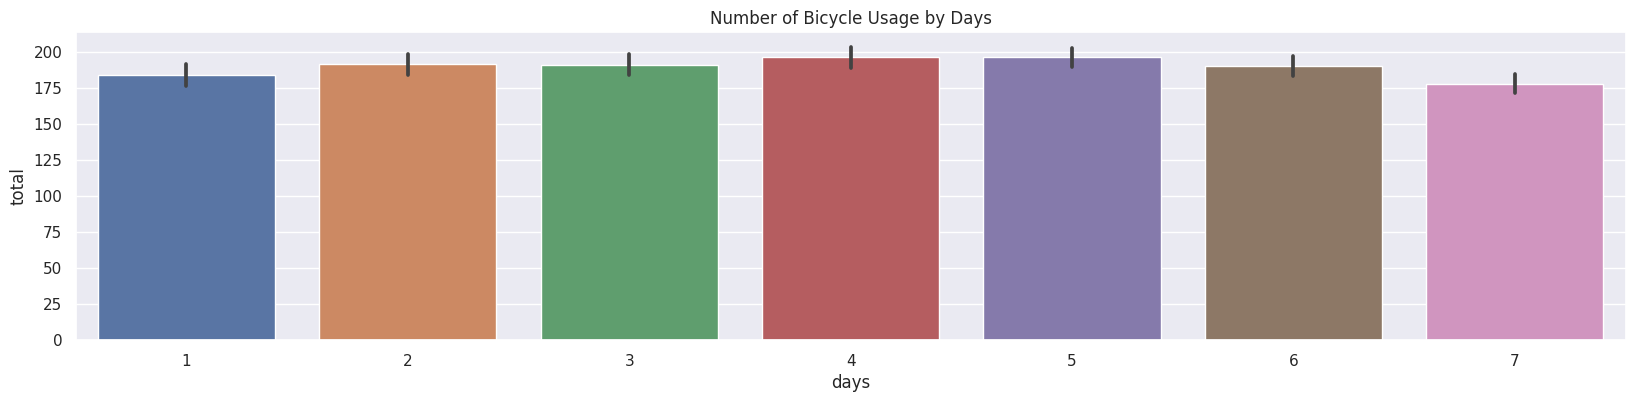

In [143]:
#Tablo 7
fig, ax = plt.subplots(figsize=(20,4))
sns.barplot(data=df, x='weekday', y='total', ax=ax)
ax.set(title="Number of Bicycle Usage by Days", xlabel="days", ylabel="total")

[Text(0.5, 1.0, 'Relations between Total Users and Humidity'),
 Text(0.5, 0, 'Humidity'),
 Text(0, 0.5, 'total users')]

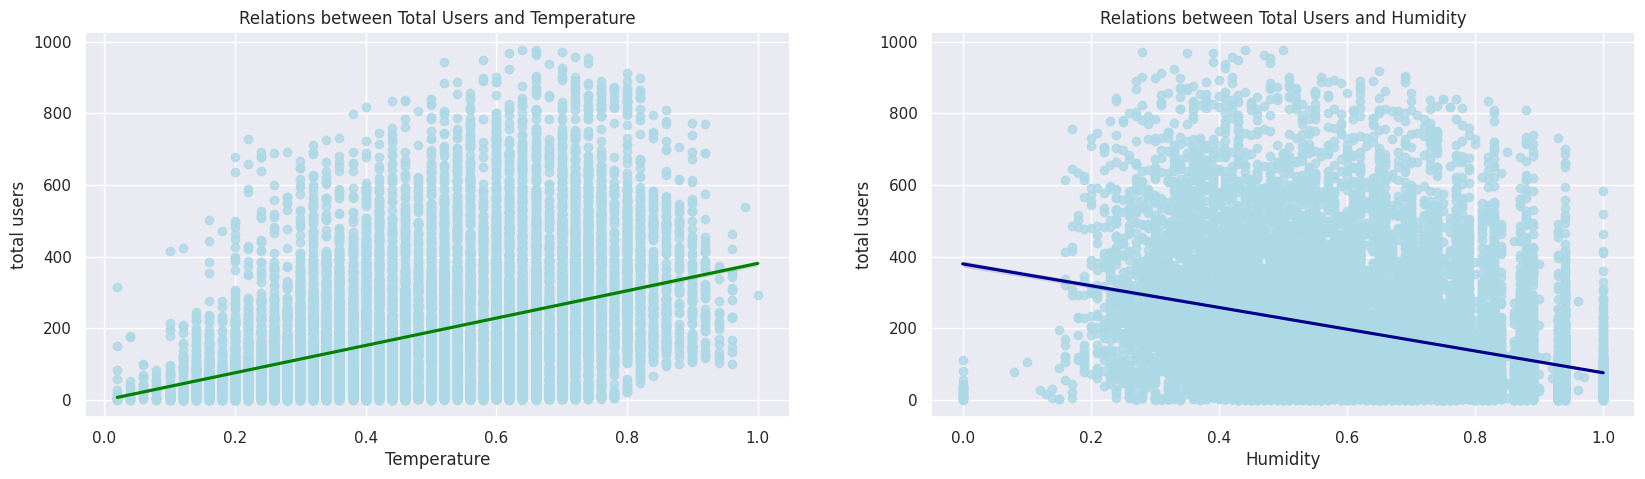

In [144]:
#Tablo 8
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20,5))
sns.regplot(x=df['temperature'], y=df['total'], ax=ax1 ,color='green',scatter_kws={'color': 'lightblue'})
ax1.set(title="Relations between Total Users and Temperature", xlabel="Temperature", ylabel="total users")

sns.regplot(x=df['humidity'], y=df['total'], ax=ax2,color='darkblue', scatter_kws={'color': 'lightblue'})
ax2.set(title="Relations between Total Users and Humidity", xlabel="Humidity", ylabel="total users")

<Axes: >

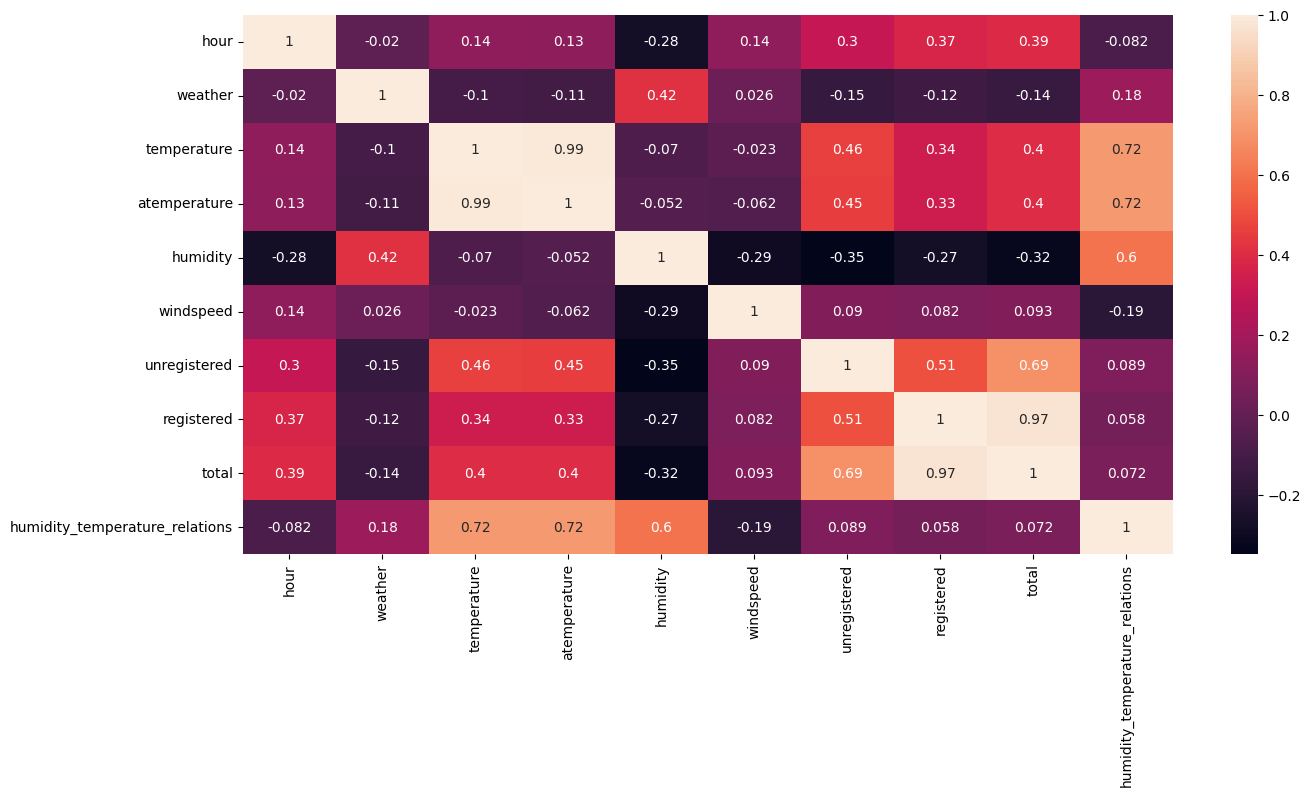

In [23]:
#Correlation Matrix
corr = df.corr()
plt.figure(figsize=(15,7))
sns.heatmap(corr, annot=True, annot_kws={'size':10})

In [145]:
#ONE HOT ENCODING

In [25]:
pd.get_dummies(df['season'], prefix='season', drop_first=True).head()
#burda da mevsim 2 yi isimlendirmemiz lazım

,season_2,season_3,season_4
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [26]:
df_oh = df

def one_hot_encoding(data, column):
    data = pd.concat([data, pd.get_dummies(data[column], prefix=column, drop_first=True)], axis=1)
    data = data.drop([column], axis=1)
    return data

cols = ['season','month','weekday','workingday','weather',"hour_category","temperature_category","humidity_ratio"]

for col in cols:
    df_oh = one_hot_encoding(df_oh, col)

In [27]:
df_oh.head()

,year,hour,temperature,atemperature,humidity,windspeed,unregistered,registered,total,humidity_temperature_relations,season_2,season_3,season_4,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,workingday_1,weather_2,weather_3,weather_4,hour_category_2,hour_category_3,hour_category_4,temperature_category_2,temperature_category_3,temperature_category_4,temperature_category_5,humidity_ratio_2,humidity_ratio_3
0,0,0,0.240,0.288,0.810,0.000,3,13,16,0.194,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,0,1,0.220,0.273,0.800,0.000,8,32,40,0.176,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0,2,0.220,0.273,0.800,0.000,5,27,32,0.176,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0,3,0.240,0.288,0.750,0.000,3,10,13,0.180,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,0,4,0.240,0.288,0.750,0.000,0,1,1,0.180,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [28]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [29]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [30]:
for col in num_cols:
    print(col, check_outlier(df_oh, col))

temperature False
atemperature False
humidity True
windspeed True
unregistered True
registered True
total True
humidity_temperature_relations False


In [31]:
for col in num_cols:
  print(col, outlier_thresholds(df_oh, col))

temperature (-0.13999999999999996, 1.1400000000000001)
atemperature (-0.09854999999999997, 1.0530499999999998)
humidity (0.029999999999999916, 1.23)
windspeed (-0.1193, 0.4775)
unregistered (-62.0, 114.0)
registered (-245.0, 499.0)
total (-321.5, 642.5)
humidity_temperature_relations (-0.18850000000000003, 0.7995000000000001)


In [32]:
for col in num_cols:
  print(col, replace_with_thresholds(df_oh, col))

temperature None
atemperature None
humidity None
windspeed None
unregistered None
registered None
total None
humidity_temperature_relations None


In [33]:
df_oh.shape

(17379, 43)

In [34]:
df_oh.head()

,year,hour,temperature,atemperature,humidity,windspeed,unregistered,registered,total,humidity_temperature_relations,season_2,season_3,season_4,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,workingday_1,weather_2,weather_3,weather_4,hour_category_2,hour_category_3,hour_category_4,temperature_category_2,temperature_category_3,temperature_category_4,temperature_category_5,humidity_ratio_2,humidity_ratio_3
0,0,0,0.240,0.288,0.810,0.000,3,13,16.000,0.194,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,0,1,0.220,0.273,0.800,0.000,8,32,40.000,0.176,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0,2,0.220,0.273,0.800,0.000,5,27,32.000,0.176,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0,3,0.240,0.288,0.750,0.000,3,10,13.000,0.180,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,0,4,0.240,0.288,0.750,0.000,0,1,1.000,0.180,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [36]:
# Bağımlı değişkeni ayırınt
total = df_oh["total"]
veri = df_oh.drop("total", axis=1)
veri.head()


,year,hour,temperature,atemperature,humidity,windspeed,unregistered,registered,humidity_temperature_relations,season_2,season_3,season_4,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,workingday_1,weather_2,weather_3,weather_4,hour_category_2,hour_category_3,hour_category_4,temperature_category_2,temperature_category_3,temperature_category_4,temperature_category_5,humidity_ratio_2,humidity_ratio_3
0,0,0,0.240,0.288,0.810,0.000,3,13,0.194,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,0,1,0.220,0.273,0.800,0.000,8,32,0.176,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0,2,0.220,0.273,0.800,0.000,5,27,0.176,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0,3,0.240,0.288,0.750,0.000,3,10,0.180,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,0,4,0.240,0.288,0.750,0.000,0,1,0.180,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [37]:
num_cols1= ['temperature',
 'atemperature',
 'humidity',
 'windspeed',
 'humidity_temperature_relations']

In [38]:
#rs = RobustScaler()
#df_oh["rs_temp"] = rs.fit_transform(df_oh[["temp"]])

rs = RobustScaler()
for col in num_cols1:
    veri[col + "_rs"] = rs.fit_transform(veri[[col]])
veri.describe().T

#for ile

#registere ı ayıralım
#saate de bakalım tekrardan 
#bu haliyle tahnin ediyor tamamne yanlış çıkmıyor, y de bağımlıda y çıkaralım


,count,mean,std,min,25%,50%,75%,max
hour,17379.000,11.547,6.914,0.000,6.000,12.000,18.000,23.000
temperature,17379.000,0.497,0.193,0.020,0.340,0.500,0.660,1.000
atemperature,17379.000,0.476,0.172,0.000,0.333,0.485,0.621,1.000
humidity,17379.000,0.627,0.193,0.030,0.480,0.630,0.780,1.000
windspeed,17379.000,0.189,0.118,0.000,0.104,0.194,0.254,0.477
unregistered,17379.000,31.159,34.813,0.000,4.000,17.000,48.000,114.000
registered,17379.000,148.645,135.352,0.000,34.000,115.000,220.000,499.000
humidity_temperature_relations,17379.000,0.309,0.145,0.000,0.182,0.299,0.429,0.623
season_2,17379.000,0.254,0.435,0.000,0.000,0.000,1.000,1.000
season_3,17379.000,0.259,0.438,0.000,0.000,0.000,1.000,1.000


In [39]:
df_ml = pd.concat([veri, total], axis=1)

In [40]:
df_ml.head()

,year,hour,temperature,atemperature,humidity,windspeed,unregistered,registered,humidity_temperature_relations,season_2,season_3,season_4,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,workingday_1,weather_2,weather_3,weather_4,hour_category_2,hour_category_3,hour_category_4,temperature_category_2,temperature_category_3,temperature_category_4,temperature_category_5,humidity_ratio_2,humidity_ratio_3,temperature_rs,atemperature_rs,humidity_rs,windspeed_rs,humidity_temperature_relations_rs,total
0,0,0,0.240,0.288,0.810,0.000,3,13,0.194,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,-0.812,-0.684,0.600,-1.300,-0.424,16.000
1,0,1,0.220,0.273,0.800,0.000,8,32,0.176,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,-0.875,-0.737,0.567,-1.300,-0.499,40.000
2,0,2,0.220,0.273,0.800,0.000,5,27,0.176,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,-0.875,-0.737,0.567,-1.300,-0.499,32.000
3,0,3,0.240,0.288,0.750,0.000,3,10,0.180,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,-0.812,-0.684,0.400,-1.300,-0.483,13.000
4,0,4,0.240,0.288,0.750,0.000,0,1,0.180,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,-0.812,-0.684,0.400,-1.300,-0.483,1.000


In [41]:
df_ml.drop("year", axis=1, inplace=True)

In [42]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_oh)

Observations: 17379
Variables: 43
cat_cols: 36
num_cols: 7
cat_but_car: 0
num_but_cat: 36


In [43]:
#############MACHINE LEARNING

In [44]:
X = df_ml.drop(columns=['atemperature', 'windspeed', 'unregistered', 'registered', 'total'], axis=1)
y = df_ml['total']

In [45]:
##### Linear Regression

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [ ]:
reg_model = LinearRegression().fit(X_train, y_train)

In [ ]:
y_pred = reg_model.predict(X_test)

In [ ]:
print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred)))

RMSE: 122.66545244679247


In [ ]:
reg_model.score(X_train, y_train)

0.49471113466609684

In [ ]:
y_pred = reg_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

122.66545244679247

In [ ]:
reg_model.score(X_test, y_test)

0.4954188711169907

In [ ]:
###### RANDOM FOREST #####

In [ ]:
rf_model = RandomForestRegressor(random_state=42)

In [ ]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [ ]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train,y_train)


RandomForestRegressor()

In [ ]:
y_pred = rf_model.predict(X_test)

In [ ]:
print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred)))

RMSE: 62.9658299716013


In [ ]:
y_pred = rf_model.predict(X_test)
error = y_test - y_pred
error

14422      1.740
4772    -242.685
9043      43.905
12189     -1.250
14937    -16.730
8286      -2.190
4393     -16.080
15681     65.970
6175     -30.050
6768     -91.410
16155     80.950
13494    -66.260
12040      7.810
4760     -35.690
11563      3.610
15027     54.240
9602      -4.860
2548      -0.250
9459       6.350
1939     -32.170
17017     -6.570
4274     -13.620
270      -39.510
2985    -143.140
11448     -7.830
3381    -128.550
4285     -85.250
13347     31.130
15862     43.190
6656      31.960
2434     -16.130
15460    100.015
11456      6.700
1835     -13.830
4272      25.030
10279     73.790
4046      -3.030
6354    -136.115
3698       2.430
3889     -12.640
6416     -38.430
6935     -71.500
7560     -53.470
1437      -5.650
5077     -21.190
3389      -0.820
12768      7.260
16444    -52.770
13160     22.050
6803     -35.970
6371      -3.810
1461      -6.450
1234      -9.960
13128      4.570
3157      -9.100
5930     -90.960
3376     -53.670
14994     18.090
1346     -60.6

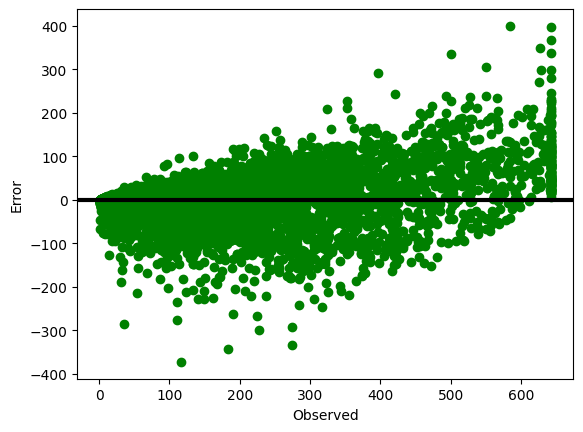

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_test, error ,color = 'green')
ax.axhline(lw=3, color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Error')
plt.show()


In [ ]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
rf_params = {"max_depth": [5, 8, None],
             "max_features": [1, 3, 5], 
             "min_samples_split": [2, 5, 8],
             "n_estimators": [100, 200, 500]}

In [ ]:
rf_best_grid = GridSearchCV(rf_model, rf_params, cv=3, verbose=True).fit(X_train,y_train)



Fitting 3 folds for each of 81 candidates, totalling 243 fits


In [ ]:
rf_best_grid.best_params_


{'max_depth': None,
 'max_features': 5,
 'min_samples_split': 2,
 'n_estimators': 500}

In [ ]:
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X_train,y_train)

In [ ]:
y_pred = rf_final.predict(X_test)

In [ ]:
print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred)))

RMSE: 77.5733684240053


In [ ]:
##### Random Fores Random Search #####

In [ ]:
rf_model = RandomForestRegressor(random_state=17)

In [ ]:
rf_random_params = {"max_depth": np.random.randint(5, 50, 10),
                    "max_features": [3, 5, 7, "auto", "sqrt"],
                    "min_samples_split": np.random.randint(2, 50, 20),
                    "n_estimators": [int(x) for x in np.linspace(start=200, stop=1500, num=10)]}

In [ ]:
rf_random = RandomizedSearchCV(estimator=rf_model,
                               param_distributions=rf_random_params,
                               n_iter=100,  # denenecek parametre sayısı
                               cv=3,
                               verbose=True,
                               random_state=42,
                               n_jobs=-1).fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [ ]:
rf_random.best_params_

{'n_estimators': 488,
 'min_samples_split': 4,
 'max_features': 'auto',
 'max_depth': 47}

In [ ]:
rf_final = rf_model.set_params(**rf_random.best_params_, random_state=17).fit(X_train,y_train)

In [ ]:
y_pred = rf_final.predict(X_test)

In [ ]:
print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred)))

RMSE: 62.515973389473615


In [107]:
##################CART##########################

In [108]:
from sklearn.tree import DecisionTreeRegressor

In [109]:
cart_model = DecisionTreeRegressor(random_state=17).fit(X_train, y_train)

In [110]:
y_pred = cart_model.predict(X_test)

In [111]:
print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred)))

RMSE: 86.59081817875013


In [112]:
#hiperparametre

In [113]:
cart_model.get_params()


{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 17,
 'splitter': 'best'}

In [114]:
cart_params = {'max_depth': range(1, 11),
               "min_samples_split": range(2, 20)}

In [115]:
cart_best_grid = GridSearchCV(cart_model,
                              cart_params,
                              cv=5,
                              n_jobs=-1,
                              verbose=1).fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [116]:
cart_best_grid.best_params_

{'max_depth': 10, 'min_samples_split': 15}

In [117]:
cart_final = DecisionTreeRegressor(**cart_best_grid.best_params_, random_state=17).fit(X, y)

In [118]:
y_pred = cart_final.predict(X_test)

In [119]:
print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred)))

RMSE: 65.27921895180805


In [120]:
##########GBM

In [121]:
gbm_model = GradientBoostingRegressor(random_state=17).fit(X_train,y_train)

In [122]:
y_pred = gbm_model.predict(X_test)

In [123]:
print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred)))

RMSE: 75.20613671420685


In [124]:
gbm_model.get_params()


{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 17,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
##hiperparametre analizi

In [126]:
gbm_model.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 17,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [127]:
gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8, 10],
              "n_estimators": [100, 500, 1000],
              "subsample": [1, 0.5, 0.7]}


In [128]:
gbm_best_grid = GridSearchCV(gbm_model, gbm_params, cv=5, n_jobs=-1, verbose=True).fit(X_train, y_train)


Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [129]:
gbm_best_grid.best_params_

{'learning_rate': 0.01,
 'max_depth': 10,
 'n_estimators': 1000,
 'subsample': 0.5}

In [130]:
gbm_final = gbm_model.set_params(**gbm_best_grid.best_params_, random_state=17, ).fit(X, y)


In [133]:
y_pred = gbm_final.predict(X_test)

In [134]:
print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred)))

RMSE: 24.993774727023407


In [ ]:
######################LIGHTGBM##################################

In [53]:
lgbm_model = LGBMRegressor(random_state=42).fit(X_train, y_train)

In [ ]:
y_pred = lgbm_model.predict(X_test)

In [ ]:
print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred)))

RMSE: 60.48973062194854


In [ ]:
#hiperparametre analizi

In [ ]:
lgbm_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 17,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [ ]:
lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [100, 300, 500, 1000],
               "colsample_bytree": [0.5, 0.7, 1]}

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X_train, y_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [ ]:
lgbm_best_grid.best_params_

{'colsample_bytree': 1, 'learning_rate': 0.1, 'n_estimators': 1000}

In [ ]:
lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X_train, y_train)

In [ ]:
y_pred = lgbm_final.predict(X_test)

In [ ]:
print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred)))

RMSE: 54.97617491882434


In [ ]:
###### LGBM Random Search ######

In [54]:

lgbm_random_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [int(x) for x in np.linspace(start=100, stop=1500, num=10)],
               "colsample_bytree": [0.2, 0.5, 0.7,1]}


In [55]:
lgbm_random = RandomizedSearchCV(estimator=lgbm_model,
                               param_distributions=lgbm_random_params,
                               n_iter=100,  # denenecek parametre sayısı
                               cv=5,
                               verbose=True,
                               random_state=42,
                               n_jobs=-1).fit(X_train, y_train)


Fitting 5 folds for each of 80 candidates, totalling 400 fits


In [56]:
lgbm_random.best_params_

{'n_estimators': 1500, 'learning_rate': 0.1, 'colsample_bytree': 0.7}

In [57]:
lgbm_final = lgbm_model.set_params(**lgbm_random.best_params_, random_state=17).fit(X, y)


In [59]:
y_pred = lgbm_final.predict(X_test)

In [60]:
print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred)))

RMSE: 25.829047654987548


In [ ]:
############################XGBOOST###################################

In [62]:
xgboost_model = XGBRegressor(random_state=17, use_label_encoder=False).fit(X_train,y_train)

In [63]:
y_pred = xgboost_model.predict(X_test)

In [64]:
print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred)))

RMSE: 57.66834048683781


In [ ]:
#hiperparametre

In [65]:
xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 500, 1000],
                  "colsample_bytree": [0.7, 1]}

In [66]:
from sklearn.model_selection import GridSearchCV

In [68]:
xgboost_best_grid = GridSearchCV(xgboost_model, xgboost_params, cv=5, n_jobs=-1, verbose=True).fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [69]:
xgboost_final = xgboost_model.set_params(**xgboost_best_grid.best_params_, random_state=17).fit(X_train, y_train)

In [70]:
y_pred = xgboost_final.predict(X_test)

In [71]:
print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred)))

RMSE: 18.813567316676824


In [ ]:
#########################CATBOOST######################

In [72]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 2.4 MB/s eta 0:00:00


In [74]:

catboost_model = CatBoostRegressor(random_state=17).fit(X_train,y_train)


Learning rate set to 0.062057
0:	learn: 164.6781425	total: 83.2ms	remaining: 1m 23s
1:	learn: 159.1395957	total: 92.2ms	remaining: 46s
2:	learn: 153.7551334	total: 109ms	remaining: 36.1s
3:	learn: 148.9021752	total: 125ms	remaining: 31s
4:	learn: 144.3655965	total: 141ms	remaining: 28.2s
5:	learn: 140.2801674	total: 157ms	remaining: 26s
6:	learn: 136.5558678	total: 196ms	remaining: 27.9s
7:	learn: 133.2002041	total: 210ms	remaining: 26s
8:	learn: 129.9706371	total: 216ms	remaining: 23.8s
9:	learn: 127.1784489	total: 220ms	remaining: 21.8s
10:	learn: 124.4566786	total: 225ms	remaining: 20.2s
11:	learn: 122.1835133	total: 232ms	remaining: 19.1s
12:	learn: 118.6139325	total: 238ms	remaining: 18.1s
13:	learn: 116.7113348	total: 244ms	remaining: 17.2s
14:	learn: 114.2570647	total: 249ms	remaining: 16.4s
15:	learn: 111.4800589	total: 275ms	remaining: 16.9s
16:	learn: 109.5485713	total: 288ms	remaining: 16.7s
17:	learn: 106.8904079	total: 298ms	remaining: 16.3s
18:	learn: 105.3205741	total: 3

In [75]:
y_pred= catboost_model.predict(X_test)

In [76]:
print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred)))

RMSE: 56.467376211536134


In [79]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


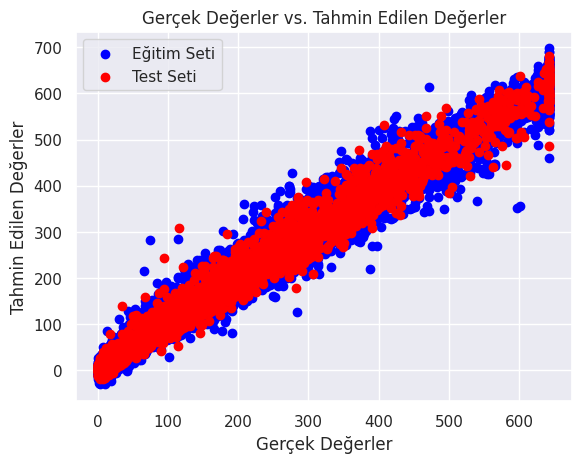

In [93]:
y_pred_train = lgbm_final.predict(X_train)
y_pred_test = lgbm_final.predict(X_test)
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
plt.scatter(y_train, y_pred_train, color='blue', label='Eğitim Seti')
plt.scatter(y_test, y_pred_test, color='red', label='Test Seti')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Edilen Değerler')
plt.title('Gerçek Değerler vs. Tahmin Edilen Değerler')
plt.legend()
plt.show()


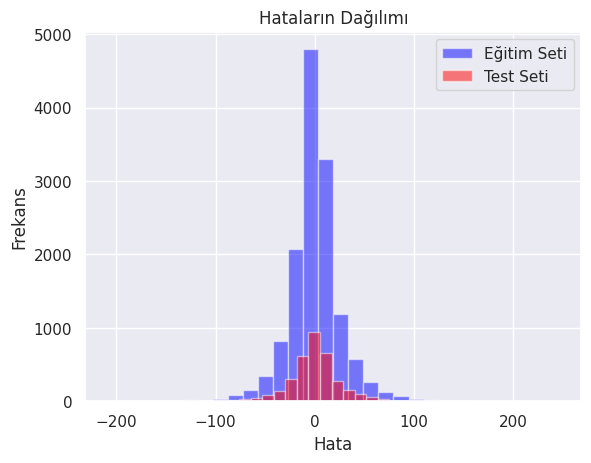

In [92]:
train_errors = y_train - y_pred_train
test_errors = y_test - y_pred_test

plt.hist(train_errors, bins=30, color='blue', alpha=0.5, label='Eğitim Seti')
plt.hist(test_errors, bins=30, color='red', alpha=0.5, label='Test Seti')
plt.xlabel('Hata')
plt.ylabel('Frekans')
plt.title('Hataların Dağılımı')
plt.legend()
plt.show()

In [88]:
print("Eğitim RMSE: ", train_rmse)

Eğitim RMSE:  26.054485887748946


In [89]:
print("Test RMSE: ", test_rmse)

Test RMSE:  25.829047654987548


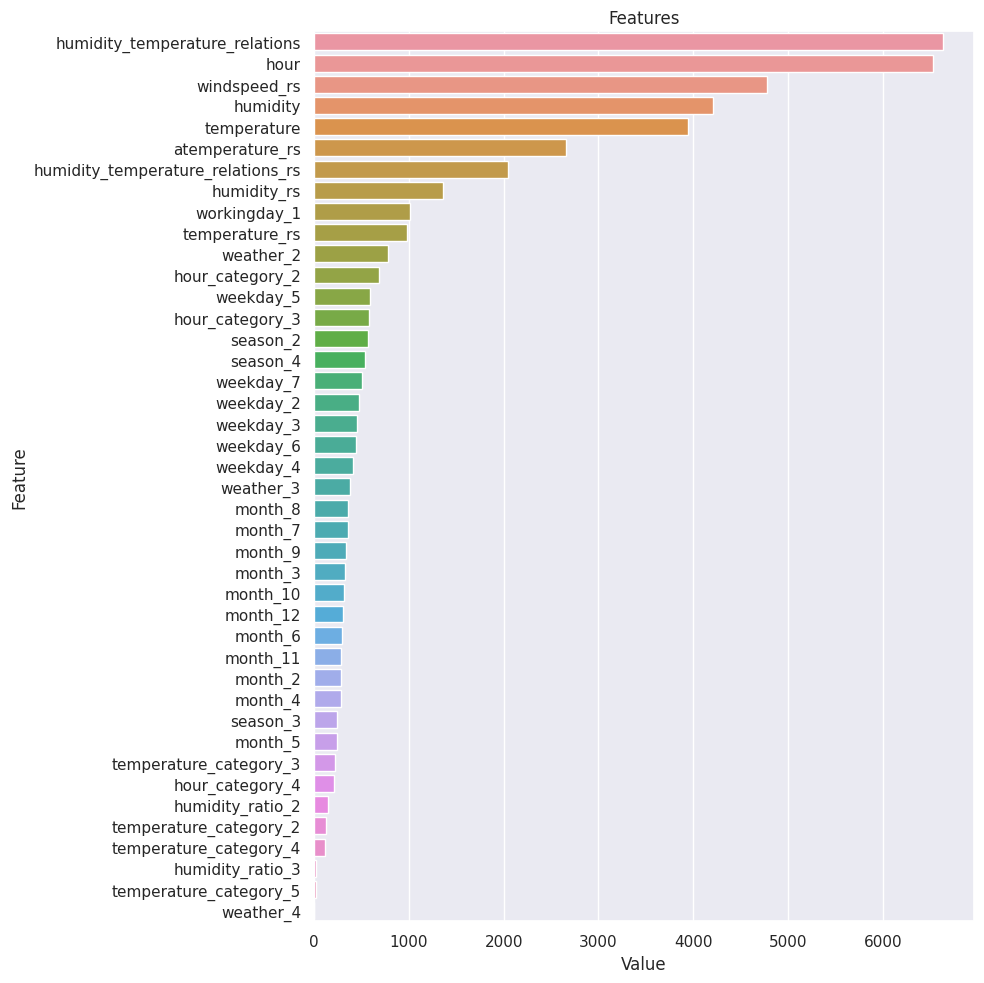

In [81]:
plot_importance(lgbm_final, X)

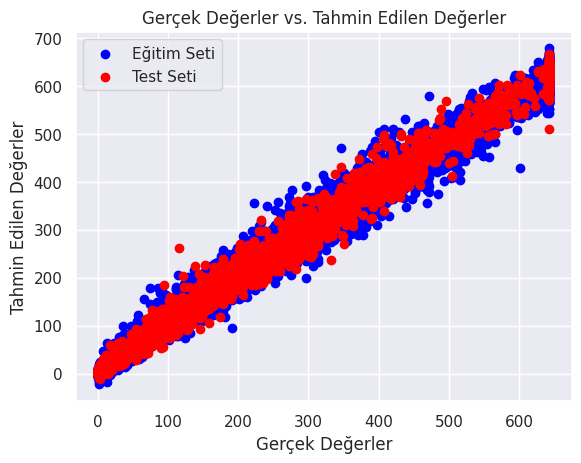

In [105]:
y_pred_train = xgboost_final.predict(X_train)
y_pred_test = xgboost_final.predict(X_test)
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
plt.scatter(y_train, y_pred_train, color='blue', label='Eğitim Seti')
plt.scatter(y_test, y_pred_test, color='red', label='Test Seti')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Edilen Değerler')
plt.title('Gerçek Değerler vs. Tahmin Edilen Değerler')
plt.legend()
plt.show()

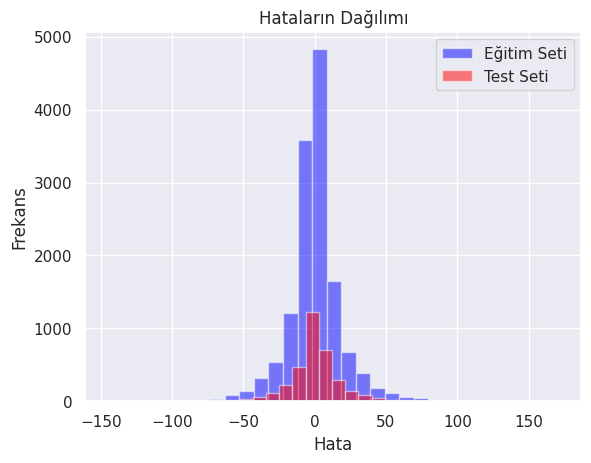

In [106]:
train_errors = y_train - y_pred_train
test_errors = y_test - y_pred_test

plt.hist(train_errors, bins=30, color='blue', alpha=0.5, label='Eğitim Seti')
plt.hist(test_errors, bins=30, color='red', alpha=0.5, label='Test Seti')
plt.xlabel('Hata')
plt.ylabel('Frekans')
plt.title('Hataların Dağılımı')
plt.legend()
plt.show()

In [ ]:
##### Tahmin

In [101]:
data = {
    'hour': [12],
    'temperature': [0.250],
    'humidity': [0.80],
    'humidity_temperature_relations': [0.196],
    'season_2': [1],
    'season_3': [0],
    'season_4': [0],
    'month_2': [0],
    'month_3': [1],
    'month_4': [0],
    'month_5': [0],
    'month_6': [0],
    'month_7': [0],
    'month_8': [0],
    'month_9': [0],
    'month_10': [0],
    'month_11': [0],
    'month_12': [0],
    'weekday_2': [0],
    'weekday_3': [0],
    'weekday_4': [1],
    'weekday_5': [0],
    'weekday_6': [0],
    'weekday_7': [0],
    'workingday_1': [1],
    'weather_2': [0],
    'weather_3': [0],
    'weather_4': [0],
    'hour_category_2': [0],
    'hour_category_3': [1],
    'hour_category_4': [0],
    'temperature_category_2': [1],
    'temperature_category_3': [0],
    'temperature_category_4': [0],
    'temperature_category_5': [0],
    'humidity_ratio_2': [0],
    'humidity_ratio_3': [0],
    'temperature_rs': [0],
    'atemperature_rs': [0],
    'humidity_rs': [0],
    'windspeed_rs': [0],
    'humidity_temperature_relations_rs': [0]
}

# Tahmin yapılacak veri setini DataFrame'e dönüştürün
input_data = pd.DataFrame(data)

# Tahminleri yapın
predictions = lgbm_model.predict(input_data)

# Tahmin sonuçlarını yazdırın
print(predictions)


[108.26125487]
